# УДАЛИТЬ

Данные эксперименты можно представить как пример действий в случае невзешенного графа

In [1]:
import os
import sys
from random import randint, seed

sys.path.append('../')

import numpy as np
import networkx as nx
from networkx.algorithms.community import louvain_communities, modularity

import leidenalg as la
from scripts.clustering import leiden
from scripts.filtration import FiltrationClustering

import matplotlib.pyplot as plt

from sklearn.metrics import adjusted_mutual_info_score
from sklearn.metrics import adjusted_rand_score

from GraphRicciCurvature.OllivierRicci import OllivierRicci
from GraphRicciCurvature.FormanRicci import FormanRicci

In [2]:
def compute_metrics(G, true_labels, pred_labels):
    # Convert communities to label lists (node order must match)
    nodes = sorted(G.nodes())
    true_labels = [true_labels[node] for node in nodes]
    pred_labels = [pred_labels[node] for node in nodes]

    nmi = adjusted_mutual_info_score(true_labels, pred_labels)
    print(f"AMI: {nmi:.5f} | interval: [0, 1]")

    ari = adjusted_rand_score(true_labels, pred_labels)
    print(f"ARI: {ari:.5f} | interval: [-0.5, 1]")


# Emails

In [3]:
# Load graph (edges)
G = nx.read_edgelist("./data/email-Eu-core.txt", nodetype=int)
G.remove_edges_from(nx.selfloop_edges(G))

# Leave only main component
nodes_subset = list(nx.connected_components(G))[0]
G = G.subgraph(nodes_subset)

# Load ground-truth communities (node: community_id)
ground_truth = {}
with open("./data/email-Eu-core-department-labels.txt") as f:
    for line in f:
        node, label = map(int, line.strip().split())
        if node in nodes_subset:
            ground_truth[node] = label

# Convert ground truth to partition format (list of sets)
ground_truth_partition = {}
for node, comm in ground_truth.items():
    ground_truth_partition.setdefault(comm, set()).add(node)
ground_truth_partition = list(ground_truth_partition.values())

pos = nx.spring_layout(G)

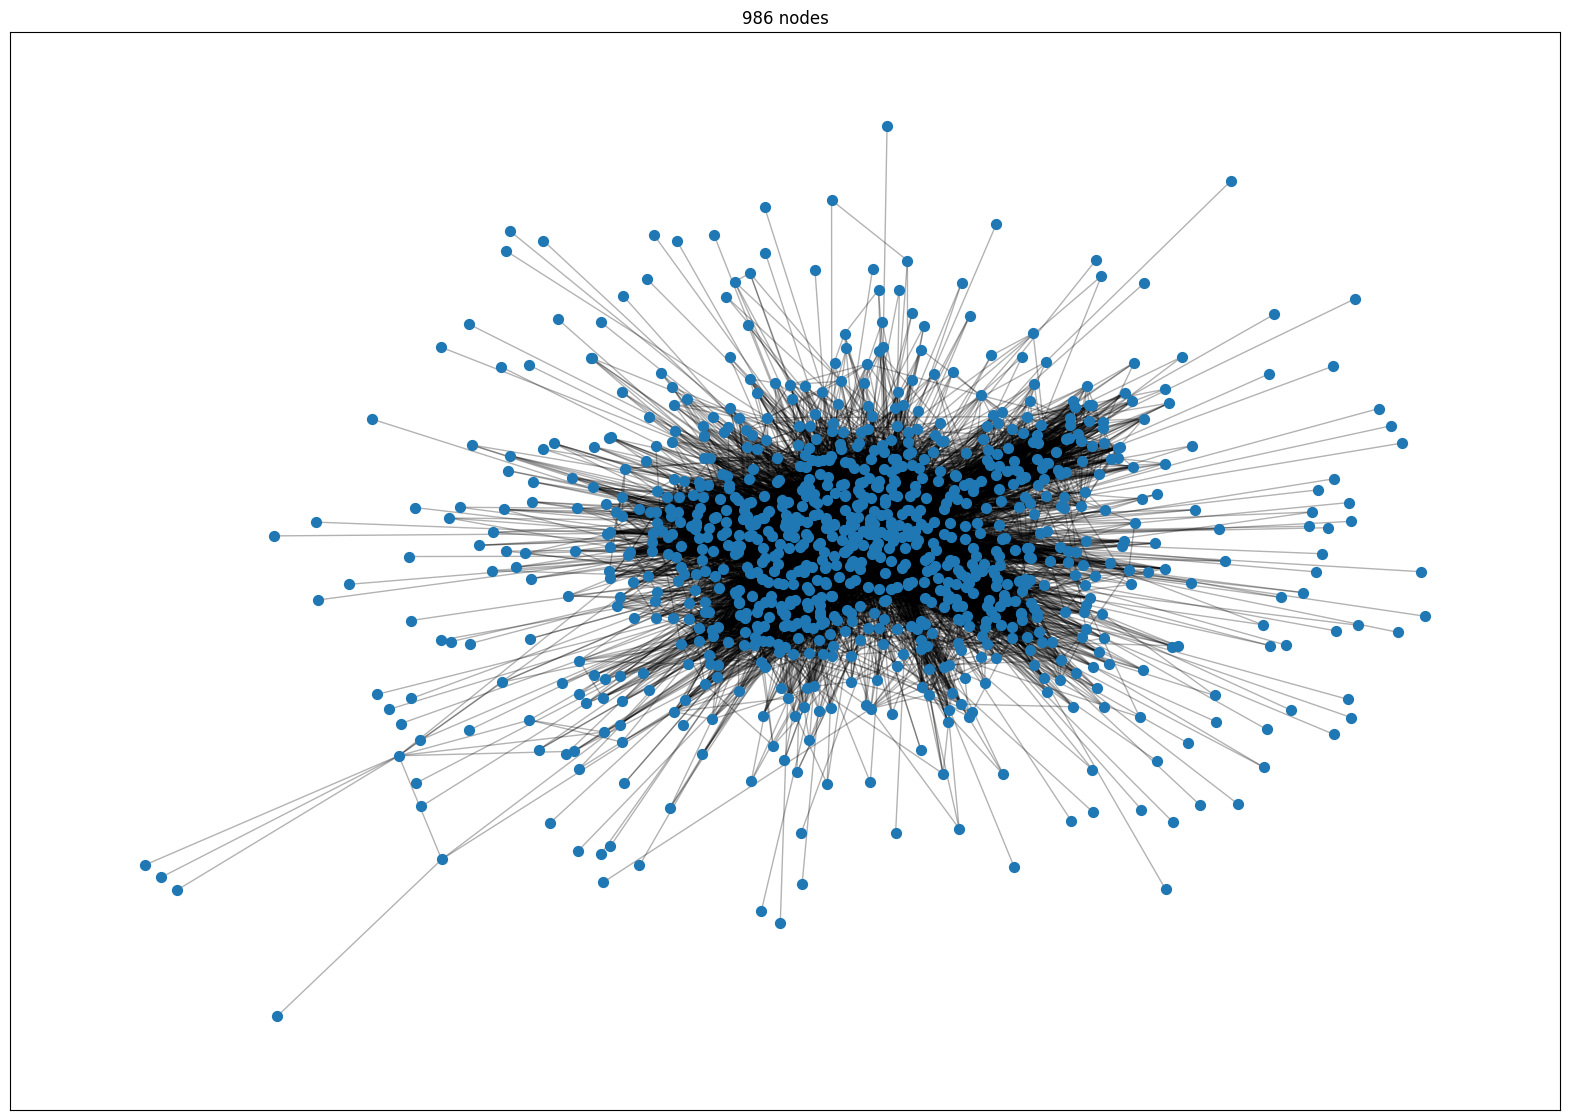

In [4]:
def plot_graph(G):
    plt.figure(figsize=(20, 14))
    nx.draw_networkx_nodes(G, pos, node_size=50)
    nx.draw_networkx_edges(G, pos, alpha=0.3)
    plt.title(f'{len(G.nodes)} nodes')


plot_graph(G)

# EXPERIMENTAL: cobound percolation

In [5]:
import igraph as ig
from itertools import combinations


def compute_triangulation(G, weight):
    # Find all triangles
    id_to_node = {id : node for id, node in enumerate(G.nodes)}
    g = ig.Graph.from_networkx(G)
    triangulation = [tuple([id_to_node[v] for v in t]) for t in g.list_triangles()]


    clique_birth = {}
    for t in triangulation:
        max_weight = 0
        for u, v in combinations(t, 2):
            if G.has_edge(u, v):
                max_weight = max(
                    max_weight, G[u][v][weight])
        clique_birth[t] = max_weight
    # Save results
    return clique_birth

In [45]:
import networkx as nx
import matplotlib.pyplot as plt

# G = nx.gnp_random_graph(20, 0.3, seed=42)
# pos = nx.spring_layout(G)

# Generate random geometric graph
G = nx.random_geometric_graph(100, 0.125, seed=42)

# Get node positions (stored as node attribute 'pos')
pos = nx.get_node_attributes(G, 'pos')

# Draw edges and nodes
plt.figure(figsize=(8, 8))
nx.draw_networkx_edges(G, pos, alpha=0.4)
nx.draw_networkx_nodes(G, pos, node_size=50)

plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.axis('off')
plt.show()

In [46]:
# Compute FormanRicci curvature
frc = FormanRicci(G)
frc.compute_ricci_curvature()
G_frc = frc.G

# Transform curvature into new metric, so that it is minimal in dense regions
for a, b in G_frc.edges:
    curv = G_frc[a][b]['formanCurvature']
    if curv < 0:
        G_frc[a][b]['curvature_transformed'] = -curv
    else:
        G_frc[a][b]['curvature_transformed'] = np.exp(-curv)


triangulation = compute_triangulation(G_frc, 'curvature_transformed')

In [47]:
co_bound = {}

for t in triangulation:
    for e in combinations(t, 2):
        e = tuple(sorted(e))
        if e in co_bound:
            co_bound[e].add(tuple(sorted(t)))
        else:
            co_bound[e] = {tuple(sorted(t))}

### TODO

**Вариант 1.**
Допустим идем по порогам (возьмем их из ребер). Делаем все те же операции, просто треугольники будем употреблять только те, которые у нас подходят по порогу. Те треугольники, которые не подошли, мы будем хранить в отдельном списке непоюзанных треугольников. Когда закончим склеку на текущем уровне, просто возьмем неюзанные треугольники в очередь.

**Вариант 2.**
Будем тогда под каждый кластер честно хранить список треугольников параллельно закидыванию их в множество склеек. процедура аналогична той что описана выше: мы употребляем только треугольники с заданным временем, а когда закончим процесс:
1. Выдаем кластеризацию для заданного эпсилон
2. Закидываем в очередь неюзанные треугльники
Только вот дальше мы итерируемся по треугольникам кластеров - ищем среди их соседей треугольники, которые подходят под данный эпсилон.

То есть в целом мы хотим держать список треугольников и для них производить махинации, а уж кластеризацию мы возьмем просто как множество вершин данных треугольников

In [ ]:
# Сортируем треугольники по рождению
# 
triangle_queue = set([tuple(sorted(t)) for t in triangulation])

coummunities = []

while triangle_queue:
    # Start with some triangle
    start = triangle_queue.pop()
    # Cluster will be formed around it
    cluster = set(start)
    # Get adjacent triangles
    neighbours_queue = [t for e in combinations(start, 2) for t in co_bound[e] if t in triangle_queue]
    # Remove them from the queue
    for t in neighbours_queue:
        triangle_queue.remove(t)
    # print(f'Start: {start} | next: {neighbours_queue}')
    # Iterate over neighbours
    while neighbours_queue:
        # Get new triangle
        next_triangle = neighbours_queue.pop()
        # Add it to cluster
        cluster.update(set(next_triangle))
        # Append new unseen triangles
        for e in combinations(next_triangle, 2):
            # Check if we have not visited it already
            for t in co_bound[e]:
                if t in triangle_queue:
                    # print(f'Cluster: {cluster} | next: {neighbours_queue}')
                    neighbours_queue.append(t)
                    # Remove them from the queue
                    triangle_queue.remove(t)
    # Add merged cluster to communities
    coummunities.append(cluster)


In [49]:
coummunities_k = list(nx.algorithms.community.k_clique_communities(G, k=3))

In [50]:
set([tuple(sorted(c)) for c in coummunities]) == set([tuple(sorted(c)) for c in coummunities_k])

True

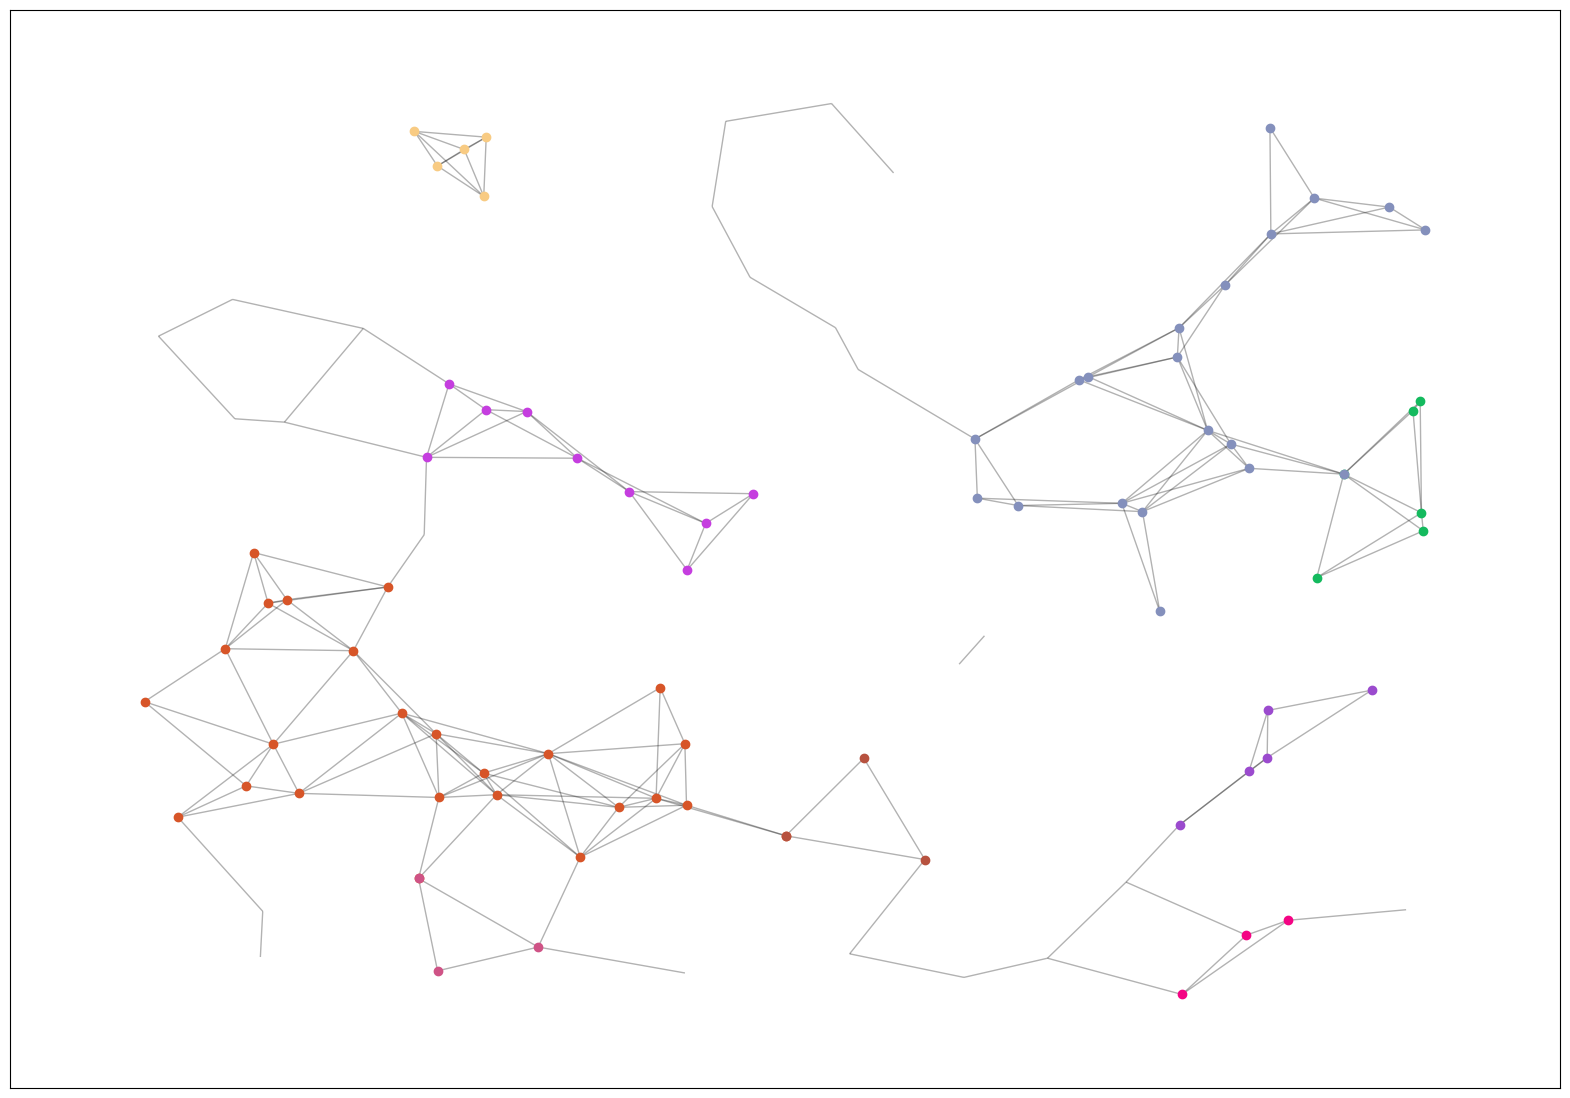

In [51]:
seed(0)

# coummunities
plt.figure(figsize=(20, 14))

nx.draw_networkx_edges(G, pos, alpha=0.3)

for j, cluster in enumerate(coummunities):
    color = '#%06X' % randint(0, 0xFFFFFF)
    for v in cluster:
        point = pos[v]
        plt.scatter(point[0], point[1], c=color)

In [52]:
seed(0)

plt.figure(figsize=(20, 14))

nx.draw_networkx_edges(G, pos, alpha=0.3)

for j, cluster in enumerate(coummunities_k):
    color = '#%06X' % randint(0, 0xFFFFFF)
    for v in cluster:
        point = pos[v]
        plt.scatter(point[0], point[1], c=color)

# EXPERIMENTAL: filtration louvain

In [5]:
import networkx as nx
from collections import defaultdict

def init_community_info(G, partition, weight='weight'):
    """Initialize community degree sums and internal edge weights."""
    degrees = dict(G.degree(weight=weight))
    community_degrees = defaultdict(float)
    community_internals = defaultdict(float)
    
    for node, comm in partition.items():
        community_degrees[comm] += degrees[node]
    
    for u, v, data in G.edges(data=True):
        w = data.get(weight, 1)
        if partition[u] == partition[v]:
            community_internals[partition[u]] += w
    
    return degrees, community_degrees, community_internals

def modularity_gain(node, comm, partition, degrees, community_degrees, community_internals, G, weight='weight'):
    """Compute modularity gain of moving node to community comm."""
    m = G.size(weight=weight)
    node_comm = partition[node]
    k_i = degrees[node]
    
    # Sum of weights of edges from node to community
    k_i_in = 0
    for neighbor, data in G[node].items():
        w = data.get(weight, 1)
        if partition[neighbor] == comm:
            k_i_in += w
    
    sum_in = community_internals.get(comm, 0)
    sum_tot = community_degrees.get(comm, 0)
    
    # If node currently in comm, remove its contribution
    if comm == node_comm:
        sum_in -= 2 * k_i_in + 0  # edges counted twice inside community
        sum_tot -= k_i
    
    delta_q = (k_i_in - (sum_tot * k_i) / (2 * m)) / m
    return delta_q

def merge_communities(partition, c1, c2):
    """Merge community c2 into c1."""
    for node, comm in partition.items():
        if comm == c2:
            partition[node] = c1

def switch_node_community(partition, node, new_comm):
    """Switch a single node to a new community."""
    partition[node] = new_comm

def modified_louvain_optimized(G, weight='weight'):
    partition = {node: node for node in G.nodes()}
    edges_sorted = sorted(G.edges(data=True), key=lambda x: x[2].get(weight, 1))
    
    degrees, community_degrees, community_internals = init_community_info(G, partition, weight)
    
    unused_edges = []
    improved = True
    
    while improved:
        improved = False
        new_unused = []
        
        for u, v, data in edges_sorted:
            comm_u = partition[u]
            comm_v = partition[v]
            if comm_u == comm_v:
                continue
            
            # Compute modularity gain for merging communities
            # Merge: all nodes in comm_v move to comm_u
            # For efficiency, approximate gain by sum of gains moving nodes in comm_v to comm_u
            # Here, we do a simplified check by summing edge weights between communities
            
            # Gain from merging communities:
            # sum of weights of edges between comm_u and comm_v
            edge_weight_between = 0
            for node_u in [u]:
                for nbr, wdata in G[node_u].items():
                    if partition[nbr] == comm_v:
                        edge_weight_between += wdata.get(weight, 1)
            # Approximate gain as sum of modularity gains moving u and v
            
            # Gain from switching u to v's community
            gain_switch_u = modularity_gain(u, comm_v, partition, degrees, community_degrees, community_internals, G, weight)
            # Gain from switching v to u's community
            gain_switch_v = modularity_gain(v, comm_u, partition, degrees, community_degrees, community_internals, G, weight)
            
            # Gain from merging communities (approximate)
            # For exact, need to compute modularity difference after merging communities
            # Here, approximate as sum of gains of switching all nodes in comm_v to comm_u
            # For simplicity, sum gains for u and v only
            gain_merge = gain_switch_u + gain_switch_v
            
            gains = [(gain_merge, 'merge'), (gain_switch_u, 'switch_u'), (gain_switch_v, 'switch_v')]
            best_gain, best_action = max(gains, key=lambda x: x[0])
            
            if best_gain > 1e-10:
                improved = True
                if best_action == 'merge':
                    merge_communities(partition, comm_u, comm_v)
                    # Update community info
                    community_degrees[comm_u] += community_degrees[comm_v]
                    community_internals[comm_u] += community_internals[comm_v]
                    del community_degrees[comm_v]
                    del community_internals[comm_v]
                elif best_action == 'switch_u':
                    switch_node_community(partition, u, comm_v)
                    community_degrees[comm_u] -= degrees[u]
                    community_degrees[comm_v] += degrees[u]
                else:  # switch_v
                    switch_node_community(partition, v, comm_u)
                    community_degrees[comm_v] -= degrees[v]
                    community_degrees[comm_u] += degrees[v]
            else:
                new_unused.append((u, v, data))
        
        if not improved and new_unused:
            # Try again on unused edges (similar logic)
            edges_sorted = new_unused
            unused_edges = []
        else:
            unused_edges = new_unused
            edges_sorted = unused_edges
    
    return partition

# Example usage:

G = nx.karate_club_graph()
partition = modified_louvain_optimized(G)
communities = defaultdict(list)
for node, comm in partition.items():
    communities[comm].append(node)
print("Detected communities:")
for comm, nodes in communities.items():
    print(f"Community {comm}: {nodes}")


Detected communities:
Community 8: [0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21]
Community 23: [8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]


In [6]:
nx.community.modularity(G, [c for _, c in communities.items()]) 

0.40362811791383213

In [7]:
c_l = nx.community.louvain_communities(G)
nx.community.modularity(G,c_l)

0.44490358126721763

# Clusterings

In [5]:
def plot_communities(communities, pos, algo_name=''):
    plt.figure(figsize=(20, 14))

    nx.draw_networkx_edges(G, pos, alpha=0.3)

    for j, cluster in enumerate(communities):
        color = '#%06X' % randint(0, 0xFFFFFF)
        for v in cluster:
            point = pos[v]
            plt.scatter(point[0], point[1], c=color)

    plt.title(f'{algo_name} | {len(communities)} clusters')

## Louvain

In [6]:
seed(0xAB0BA)

# Run Louvain with default parameters
louvain_partition = louvain_communities(G, seed=42)
print(f'Modularity: {modularity(G, louvain_partition):.5f}')

# Convert Louvain output to node: community_id format
louvain_labels = {}
for i, comm in enumerate(louvain_partition):
    for node in comm:
        louvain_labels[node] = i

compute_metrics(G, ground_truth, louvain_labels)

plot_communities(louvain_partition, pos, algo_name='Louvain')

Modularity: 0.41112
AMI: 0.56665 | interval: [0, 1]
ARI: 0.35809 | interval: [-0.5, 1]


## Leiden

In [7]:
seed(0xAB0BA)

communities = leiden(G, partition_type=la.ModularityVertexPartition, seed=0xAB0BA)

print(f'Modularity: {modularity(G, communities):.5f}')

# Convert Louvain output to node: community_id format
leiden_labels = {}
for i, comm in enumerate(communities):
    for node in comm:
        leiden_labels[node] = i

compute_metrics(G, ground_truth, leiden_labels)

plot_communities(communities, pos, algo_name='Leiden')

Modularity: 0.41745
AMI: 0.56902 | interval: [0, 1]
ARI: 0.34366 | interval: [-0.5, 1]


## Filtration
Because graphs here may not have weights, we will use graph curvature instead.


In [8]:
# print("\n===== Compute the Ollivier-Ricci curvature of the given graph G =====")
# # compute the Ollivier-Ricci curvature of the given graph G
# orc = OllivierRicci(G, alpha=0.5, verbose="INFO")
# orc.compute_ricci_curvature()
# print("Karate Club Graph: The Ollivier-Ricci curvature of edge (0,1) is %f" % orc.G[0][1]["ricciCurvature"])

# print("\n===== Compute the Forman-Ricci curvature of the given graph G =====")
# frc = FormanRicci(G)
# frc.compute_ricci_curvature()
# print("Karate Club Graph: The Forman-Ricci curvature of edge (0,1) is %f" % frc.G[0][1]["formanCurvature"])

# # -----------------------------------
# print("\n=====  Compute Ricci flow metric - Optimal Transportation Distance =====")
# G = nx.karate_club_graph()
# orc_OTD = OllivierRicci(G, alpha=0.5, method="OTD", verbose="INFO")
# orc_OTD.compute_ricci_flow(iterations=10)
# print("\n=====  Compute Ricci community - by Ricci flow =====")
# clustering = orc_OTD.ricci_community()

In [ ]:
# Compute OllivierRicci curvature
orc = OllivierRicci(G, alpha=0.5, verbose="INFO")
orc.compute_ricci_curvature()
G_orc = orc.G

# Transform curvature into new metric, so that it is minimal in dense regions
for a, b in G_orc.edges:
    G_orc[a][b]['curvature_transformed'] = np.exp(-G_orc[a][b]['ricciCurvature'])

Performing Filtration Clustering


100%|██████████| 100/100 [01:15<00:00,  1.33it/s]


Finding best clustering


100%|██████████| 100/100 [00:00<00:00, 105.47it/s]


Best threshold 0.8476 with score: 0.29033768554831635
Modularity: 0.32745
AMI: 0.56404 | interval: [0, 1]
ARI: 0.29761 | interval: [-0.5, 1]


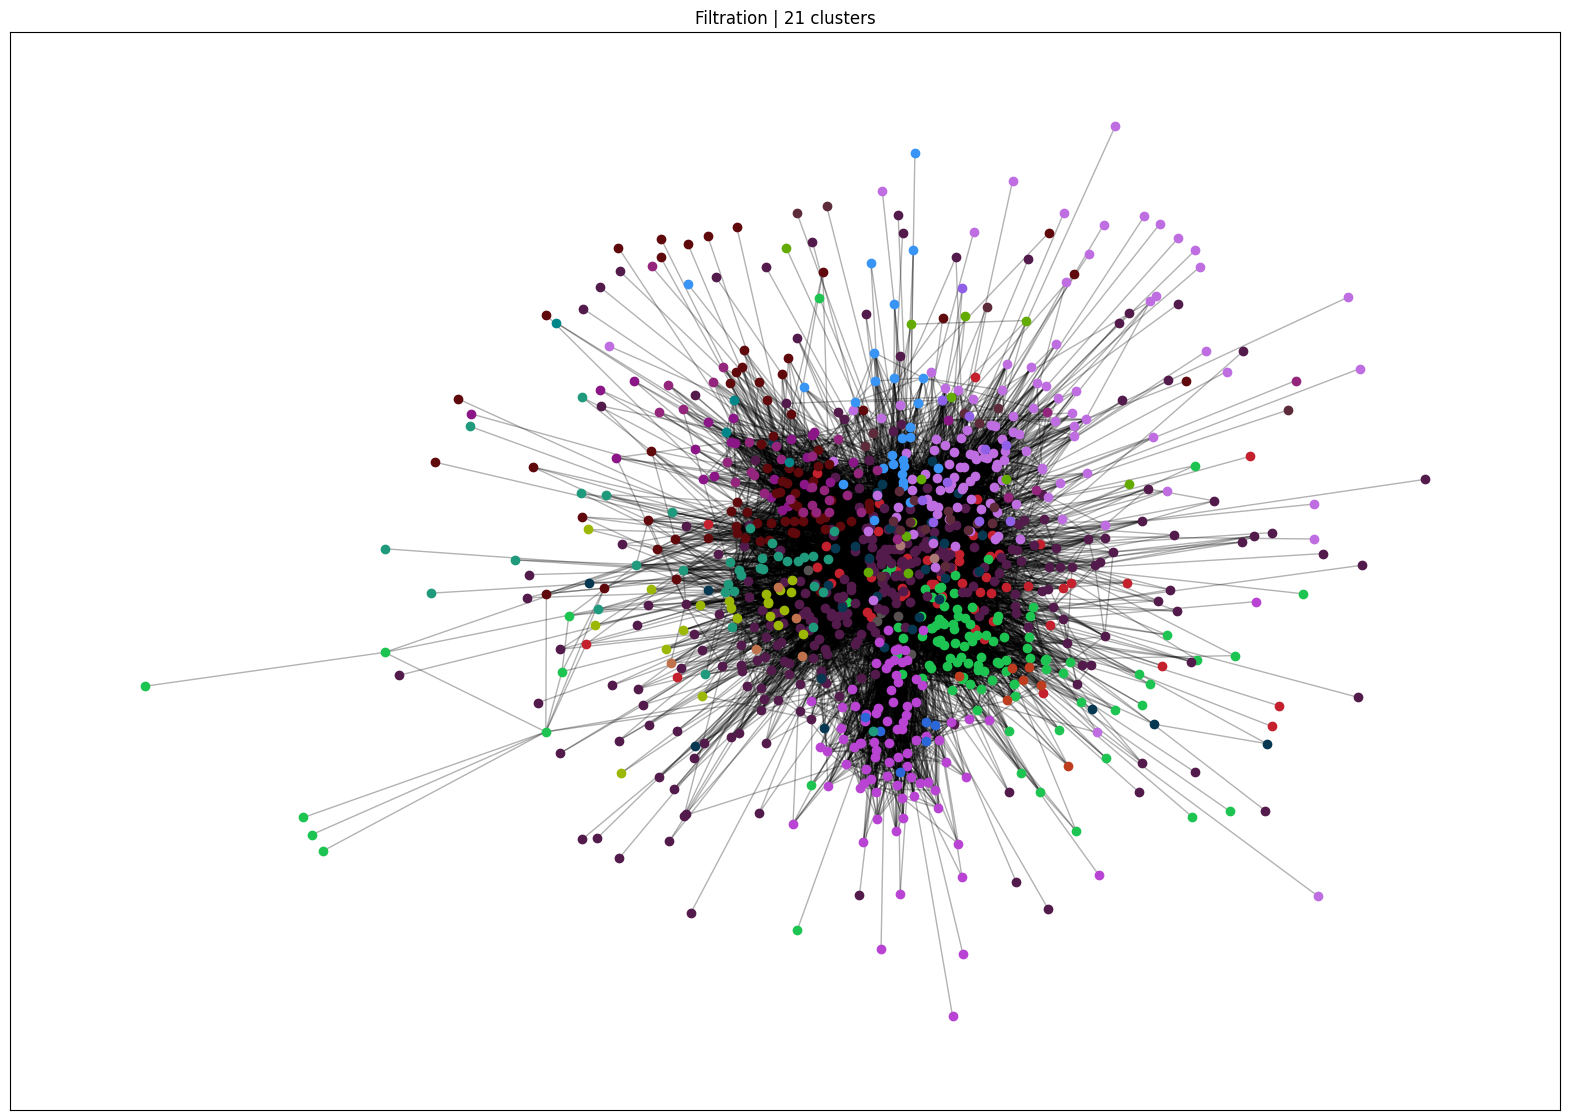

In [7]:
np.random.seed(0xAB0BA)
seed(0xAB0BA)

fc = FiltrationClustering(G_orc, weight='curvature_transformed')
communities = fc.cluster(n_jobs=os.cpu_count()-1)

print(f'Modularity: {modularity(G, communities):.5f}')

# Convert Louvain output to node: community_id format
clustering_labels = {}
for i, comm in enumerate(communities):
    for node in comm:
        clustering_labels[node] = i

compute_metrics(G, ground_truth, clustering_labels)

plot_communities(communities, pos, algo_name='Filtration')

In [9]:
# Compute FormanRicci curvature
frc = FormanRicci(G)
frc.compute_ricci_curvature()
G_frc = frc.G

# Transform curvature into new metric, so that it is minimal in dense regions
for a, b in G_frc.edges:
    G_frc[a][b]['curvature_transformed'] = np.exp(-G_frc[a][b]['formanCurvature'])

Performing Filtration Clustering


100%|██████████| 100/100 [01:14<00:00,  1.34it/s]


Finding best clustering


100%|██████████| 100/100 [00:00<00:00, 105.62it/s]


Best threshold 51271710169083303699123987077660644232404405716317080364263669760.0000 with score: -5.580512252578085e-08
Modularity: 0.00366
AMI: 0.01048 | interval: [0, 1]
ARI: 0.00156 | interval: [-0.5, 1]


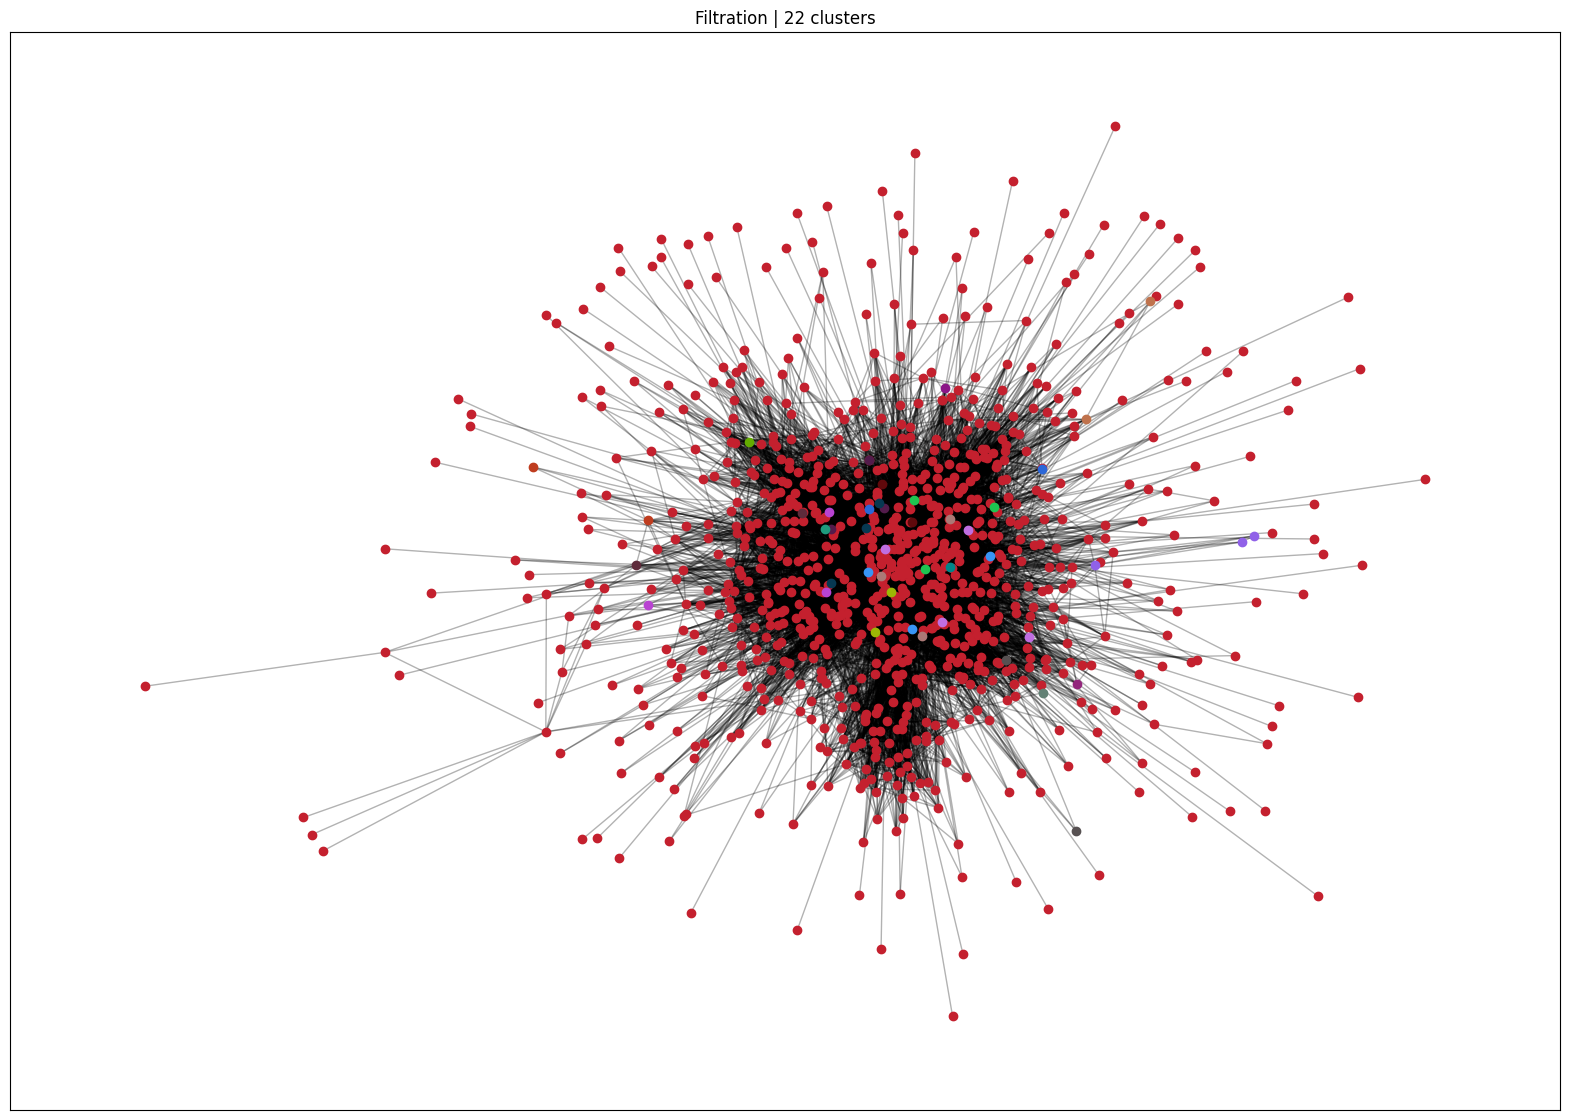

In [10]:
np.random.seed(0xAB0BA)
seed(0xAB0BA)

fc = FiltrationClustering(G_frc, weight='curvature_transformed')
communities = fc.cluster(n_jobs=os.cpu_count()-1)

print(f'Modularity: {modularity(G, communities):.5f}')

# Convert Louvain output to node: community_id format
clustering_labels = {}
for i, comm in enumerate(communities):
    for node in comm:
        clustering_labels[node] = i

compute_metrics(G, ground_truth, clustering_labels)

plot_communities(communities, pos, algo_name='Filtration')